# Marketing Mix Modeling with State Space Gaussian Processes

Dr. Juan Camilo Orduz's [blog](https://juanitorduz.github.io/) is a treasure trove of practical examples on Bayesian modeling for data scientists. This notebook supplements his post ["Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns"](https://juanitorduz.github.io/pymc_mmm/) by reproducing the "Adstock-Saturation-Diminishing-Returns Model" using state space Gaussian processes. The plots and visuals are all by Dr Orduz with small modifications. 

The state space model implemented here is of the basic linear Gaussian variety and the likelihood is evaluated with the Kalman filter. When combined with Bayesian posterior computation, the Kalman filter likelihood, although much faster than the multivariate normal likelihood, is still quite slow. I use Numpyro's stochastic variational inference to get around this problem. Another issue with the linear Gaussian ssm is that imposing non-negative priors might not be feasible. The results of the inference show that this is not a major problem. We will see that the state space Gaussian process model estimates the true parameter values with greater accuracy.

In [1]:
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler
import xarray as xr

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import math
import jax
from jax import vmap
import jax.numpy as jnp
import jax.scipy.linalg as slg
from jax.scipy.stats import norm as dnorm
import jax.random as random

from numpyro.handlers import scope, plate
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.infer.autoguide import AutoMultivariateNormal
from numpyro.infer.util import initialize_model, Predictive
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_median,
    init_to_sample,
)

rng_key = random.PRNGKey(seed=42)
numpyro.set_host_device_count(4)
numpyro.enable_x64()

### State Space GP model matrix functions

In [3]:
def Fmatern(ell, D):
    """Feedback matrix F corresponding to 
    a GP defined by a Matérn-type covariance function
    with ν=D-1/2 and length-scale ell.
    """
    F = jnp.eye(D,k=1)
    lam = np.sqrt(2*D-1)/ell
    for j in range(D):
        F = F.at[D-1,j].set(-math.comb(D,j)*lam**(D-j))
    return F

def Pmatern(F):
    """Steady state covariance matrix P corresponding
    to feedback matrix F of a Matérn GP.
    """
    D = F.shape[0]
    lam = -F[D-1,D-1]/D
    q = (2*lam)**(2*D-1) / math.comb(2*D-2,D-1)
    Fkron_sum = jnp.kron(jnp.eye(D),F) + jnp.kron(F, jnp.eye(D))
    P = slg.solve(Fkron_sum, jnp.hstack((jnp.zeros(D*D-1),-q)))
    return jnp.reshape(P,(D,D), order = 'F')

def Fperiod(J, per):
    """Feedback matrix F of a periodic
    GP with a covariance function
    defined by a sum of J cosines.
    """
    omega = 2*np.pi/per
    F = jnp.zeros((J*2,J*2))
    for i in range(J):
        F=F.at[2*i+1,2*i].set(omega*(i+1))
        F=F.at[2*i,2*i+1].set(-omega*(i+1))
    return F

def Pperiod(J, ell):
    """Initial state covariance matrix of 
    a periodic kernel based on sum of J cosines.
    """
    v = jnp.zeros(J)
    for j in range(J):
        n = (J-j-1)//2
        for i in range(n+1):
            v = v.at[j].add((2*ell**2)**(-j-1-2*i)/(math.factorial(i+j+1)*math.factorial(i))) 
    P = jnp.diag(jnp.repeat(v,2))
    return 2*P/jnp.exp(ell**(-2))

def QIntWiener(dt, D):
    """Prediction step covariance matrix Q 
    of a (D-1)-times integrated Wiener process.
    """
    A = slg.expm(np.eye(D,k=1)*dt)
    seq = jnp.arange(D)
    I = dt/(2*D-1-seq-seq[:,None])
    L = jnp.append(jnp.zeros(D-1),1)
    return I*jnp.outer((A@L),(A@L))

### GP module functions
The functions in the cell below return initial feedback, covariance and observation model matrices of a state space GP model element. These functions are supposed to be called with the Numpyro 'scope' effect handler. The functions take as arguments the mean and variance of the lognormal prior of the length scale parameter. The inverse gamma (3,2) prior for the marginal variance $\alpha$ assumes that the data is scaled accordingly.

In [4]:
def matern_gp(D,mu_ell,scale_ell):
    """mu, sigma: mean & std of lognormal prior of length scale.
    D: dimension of feedback matrix. D=ν+1/2.
    """
    alpha = numpyro.sample("alpha", dist.InverseGamma(3,2))
    length = numpyro.sample("length", dist.LogNormal(mu_ell,scale_ell))
    F = Fmatern(length, D)
    P = alpha*Pmatern(F)
    H = jnp.hstack((jnp.ones((1,1)),jnp.zeros((1,D-1))))
    return F, P, H

def quasi_period_gp(J,per,mu_ell,scale_ell):
    """int J: n of cosines summed in periodic covariance.
    per: length of period.
    mqp, sqp: mean & std of lognormal prior of quasi periodic
    length scale.
    """
    alpha = numpyro.sample("alpha", dist.InverseGamma(3,2))
    length = numpyro.sample("len_per", dist.InverseGamma(3,2))
    len_qp = numpyro.sample("len_qp", dist.LogNormal(mu_ell,scale_ell))
    F = Fperiod(J,per) - 1/(len_qp)*jnp.eye(2*J)
    P = alpha*Pperiod(J,length)
    H = np.tile([[1,0]],J)
    return F, P, H

def polynomial_gp(D):
    """Fits a polynomial of degree D.
    """
    alpha = numpyro.sample("alpha", dist.InverseGamma(3.0,2.0))
    sigma = numpyro.sample("sigma", dist.InverseGamma(3.0,2.0))
    v = jnp.power(sigma, jnp.arange(D+1))
    P = alpha*jnp.outer(v,v)
    F = jnp.eye(D+1,k=1)
    H = jnp.hstack((jnp.ones((1,1)),jnp.zeros((1,D))))
    return F,P,H

### Kalman filter and smoother functions
These are written to be used with the Numpyro [scan](https://num.pyro.ai/en/stable/primitives.html#scan) primitive. `y,X` are the observation and corresponding row $[z_t \,\, 1]$ of the regressor matrix. The latent state variable consists of a time varying regression coefficient, which we call the $\beta$-process, and an autoregressive GP component. The observation model matrix `H` in the `carry` tuple has two rows, the first row containinig the observation model matrix of the $\beta$ process. `Ht = X[None,:]@H` then gives the proper observation model matrix with the 1st row of `H` multiplied by $z_t$, the saturated adstock value at time $t$.

The Kalman filter function returns the updated carry tuple and a tuple containing the inputs to the smoother functions. In the smoother function the return values `H@m, H@P@H.T` are a $2 \times 1$ vector and its covariance matrix with the $\beta$-process as the first entry and the temporal gp as the second entry. 

In [8]:
def Kalman_filter(carry, xs):
    m, P, A, Q, H, sigma = carry
    y, X = xs
    m = A@m
    P = A@P@A.T + Q
    Ht = X[None,:]@H
    S = Ht@P@Ht.T + sigma
    K = slg.solve(S,Ht@P).T
    v = y-Ht@m
    mt = m + K@v
    L = jnp.eye(P.shape[0]) - K@Ht
    Pt = L@P
    L = A@L
    return (mt,Pt,A,Q,H,sigma), (m,P,L,S,v)

def smoother(carry, xs):
    r, N, H = carry
    m, P, L, S, v, X = xs
    Ht = X[None,:]@H
    invSH = slg.solve(S,Ht)
    r = invSH.T@v + L.T@r
    m = m + P@r
    N = L.T@N@L + Ht.T@invSH
    P = P - P@N@P
    return (r, N, H), (H@m, H@P@H.T)

In [9]:
data_path = "https://raw.githubusercontent.com/juanitorduz/website_projects/master/data/ktr_data.csv"

data_df = pd.read_csv(data_path, parse_dates=["date"])

data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 179 non-null    int64         
 1   date                  179 non-null    datetime64[ns]
 2   year                  179 non-null    int64         
 3   month                 179 non-null    int64         
 4   dayofyear             179 non-null    int64         
 5   z                     179 non-null    float64       
 6   z_adstock             179 non-null    float64       
 7   z_adstock_saturated   179 non-null    float64       
 8   beta                  179 non-null    float64       
 9   z_effect              179 non-null    float64       
 10  effect_ratio          179 non-null    float64       
 11  effect_ratio_smooth   179 non-null    float64       
 12  trend                 179 non-null    float64       
 13  cs                  

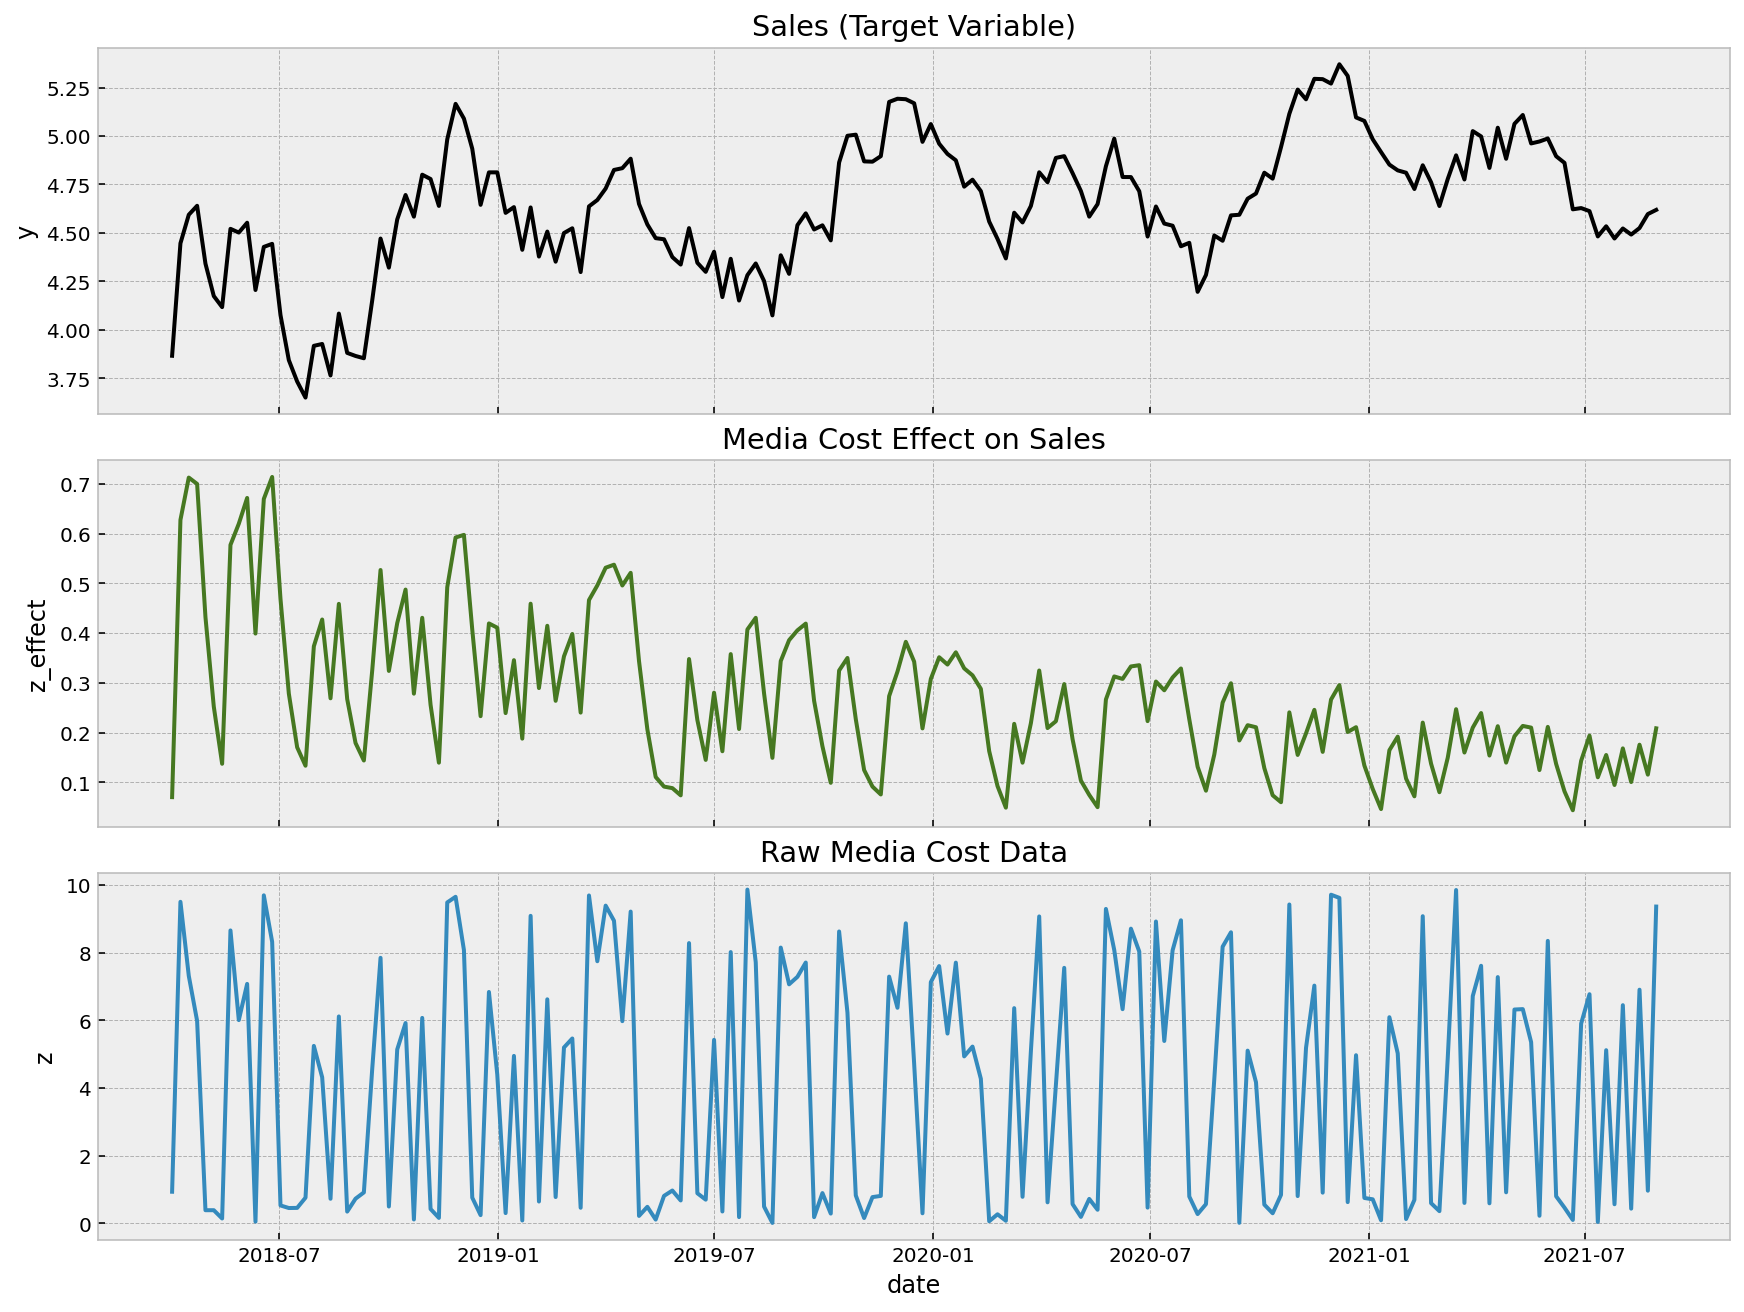

In [10]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained"
)
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=ax[0])
ax[0].set(title="Sales (Target Variable)")
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, ax=ax[1])
ax[1].set(title="Media Cost Effect on Sales")
sns.lineplot(x="date", y="z", data=data_df, ax=ax[2])
ax[2].set(title="Raw Media Cost Data");

In [11]:
columns_to_keep = ["index", "date", "year", "month", "dayofyear", "z", "y"]

df = data_df[columns_to_keep].copy()

In [12]:
date = df["date"].to_numpy()
date_index = df.index
y = df["y"].to_numpy()
z = df["z"].to_numpy()
n_obs = y.size

In [13]:
endog_scaler = MaxAbsScaler()
endog_scaler.fit(y.reshape(-1, 1))
y_scaled = endog_scaler.transform(y.reshape(-1, 1)).flatten()

channel_scaler = MaxAbsScaler()
channel_scaler.fit(z.reshape(-1, 1))
z_scaled = channel_scaler.transform(z.reshape(-1, 1)).flatten()

In [14]:
def geometric_adstock(x, alpha: float = 0.0, l_max: int = 12):
    """Geometric adstock transformation."""
    cycles = [
        jnp.concatenate(
            [jnp.zeros(i), x[: x.shape[0] - i]]
        )
        for i in range(l_max)
    ]
    x_cycle = jnp.stack(cycles)
    w = jnp.array([jnp.power(alpha, i) for i in range(l_max)])
    return jnp.dot(jnp.moveaxis(w,0,-1), x_cycle)


def logistic_saturation(x, lam: float = 0.5):
    """Logistic saturation transformation."""
    return (1 - jnp.exp(-lam * x)) / (1 + jnp.exp(-lam * x))

### Numpyro model function
The adstock parameter $\alpha$ and saturation parameter $\lambda$ have the same priors as in Dr Orduz's notebook. The yearly seasonality is modelled by a quasi periodic Gaussian process defined by a covariance function in which the periodic part consists of a sum of 2 (`J=2`) cosines. The $\beta$ process and the trend GP are both modelled by a Matérn process with $\nu=3/2$.

In the model timescale 1.0 equals one week. All of the length scale parameters have strong lognormal priors that restrict the parameter values to be larger than ~10. The zero in `A = slg.expm(slg.block_diag(Fbeta,0,Ftrend,Fyear))` and a corresponding .5 variance in the initial state covariance matrix `P` encode a constant mean. 

The `"likelihood"` site is based on the model assumption $v_t \sim \mathcal{N}(0,S_t)$ where $v_t=y_t-H m_{t|t-1}$ and $S_t=H P_{t|t-i} H^T + \sigma_t$ are predictive residuals and variances returned by the filter function. 



In [15]:
def MMM_model(y,z):
    ## adstock effect
    alpha = numpyro.sample("alpha", dist.Beta(1,1))
    ## saturation effect
    lam = numpyro.sample("lam", dist.Gamma(1,1))
    ##
    sigma = numpyro.sample("sigma", dist.Gamma(2,2))
    z_adstock = geometric_adstock(x=z, alpha=alpha, l_max = 12)
    z_adstock_saturated = logistic_saturation(x=z_adstock, lam=lam)
    # Yearly seasonality model matrices
    Fyear, Pyear, Hyear = scope(
        quasi_period_gp, "year_gp")(J=2, per=365.24/7.0, mu_ell=4.0, scale_ell=.6)
    # Trend model matrices
    Ftrend, Ptrend, Htrend = scope(
        matern_gp, "trend_gp")(D=2, mu_ell=4.0, scale_ell=.4)
    # Beta process model matrices
    Fbeta, Pbeta, Hbeta = scope(
        matern_gp, "beta_gp")(D=2, mu_ell=4.0, scale_ell=.4)
    A = slg.expm(slg.block_diag(Fbeta,0,Fyear,Ftrend))
    P = slg.block_diag(Pbeta,.5,Pyear,Ptrend)
    Q = P - A@P@A.T
    H = slg.block_diag(Hbeta, jnp.hstack((jnp.ones((1,1)),Hyear,Htrend)))
    Sdim = A.shape[0]
    init_tuple = (jnp.zeros((Sdim,1)),P,A,Q,H,sigma)
    X = jnp.stack((z_adstock_saturated, jnp.ones_like(z)),axis=1)
    
    _, smoother_inputs = scan(Kalman_filter,init_tuple,(y, X))
    _, smooth_state = scan(smoother,
         (jnp.zeros((Sdim,1)),jnp.zeros((Sdim,Sdim)),H),
        smoother_inputs+(X,), reverse = True
    )
    numpyro.sample("likelihood", dist.Normal(0,smoother_inputs[-2]), obs=smoother_inputs[-1])
    numpyro.deterministic("gp_posteriors", smooth_state)
    numpyro.deterministic("z_adstock_saturated", z_adstock_saturated)
    

### Numpyro stochastic variational inference
In Numpyro terminology the variational distribution used to approximate the true posterior is called 'guide'. Here I set the variational distribution using Numpyro's automatic guide generator. 

In [40]:
guide = AutoMultivariateNormal(model=MMM_model)
optimizer = numpyro.optim.Adam(step_size=0.025)
svi = SVI(MMM_model, guide, optimizer, loss=Trace_ELBO(8))
rng_key, rng_subkey = random.split(key=rng_key)
n_samples = 1000
svi_result = svi.run(rng_subkey, n_samples, y_scaled, z_scaled)



100%|█████████████████████████| 1000/1000 [00:26<00:00, 37.25it/s, init loss: 559.2915, avg. loss [951-1000]: -494.8912]


The ELBO converges nicely

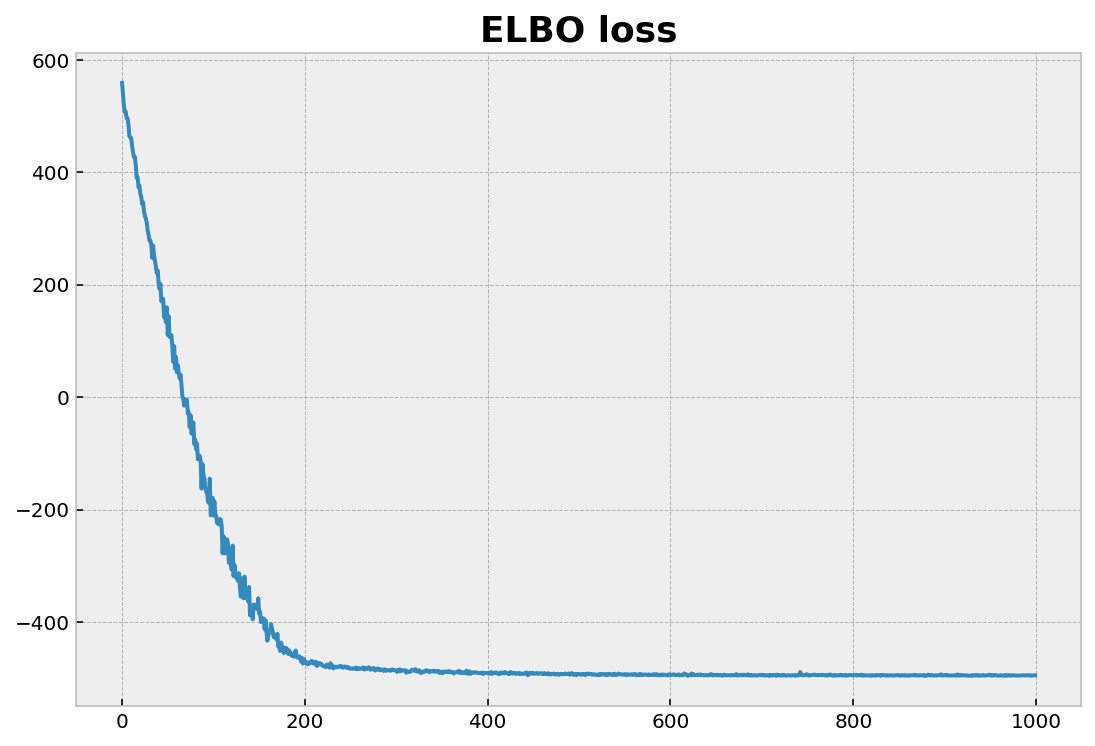

In [41]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold")

In [42]:
params = svi_result.params

# get posterior samples (parameters)
predictive = Predictive(model=guide, params=params, num_samples=5_000)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_samples = predictive(rng_subkey, y_scaled, z_scaled)
# get posterior predictive (deterministics and likelihood)
predictive = Predictive(model=MMM_model, params=params, posterior_samples=posterior_samples)
rng_key, rng_subkey = random.split(key=rng_key)
samples = predictive(rng_subkey, y_scaled, z_scaled)

In [43]:
idata_svi = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in posterior_samples.items()
    },
)

### Posterior distributions
The posterior means of $\alpha$ and $\lambda$ are pretty close to the true values 0.5 and 1.5.

In [44]:
az.summary(data=idata_svi, round_to=3)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
_auto_latent[0],0.004,0.123,-0.237,0.225,0.002,0.001,5047.471,5034.558,NaN
_auto_latent[1],0.394,0.178,0.061,0.733,0.003,0.002,4909.534,4969.647,NaN
_auto_latent[2],-4.997,0.082,-5.157,-4.850,0.001,0.001,5080.126,4851.287,NaN
_auto_latent[3],-0.631,0.431,-1.443,0.185,0.006,0.004,4623.062,4897.011,NaN
_auto_latent[4],-0.761,0.082,-0.917,-0.608,0.001,0.001,4593.609,4906.814,NaN
_auto_latent[5],5.782,0.461,4.864,6.604,0.007,0.005,4881.634,4849.869,NaN
_auto_latent[6],0.455,0.509,-0.505,1.396,0.007,0.005,4851.605,4830.310,NaN
_auto_latent[7],5.177,0.275,4.653,5.673,0.004,0.003,4976.283,4895.546,NaN
_auto_latent[8],-0.916,0.388,-1.669,-0.198,0.006,0.004,4786.135,5007.053,NaN
_auto_latent[9],4.566,0.291,4.045,5.138,0.004,0.003,4849.142,5025.257,NaN


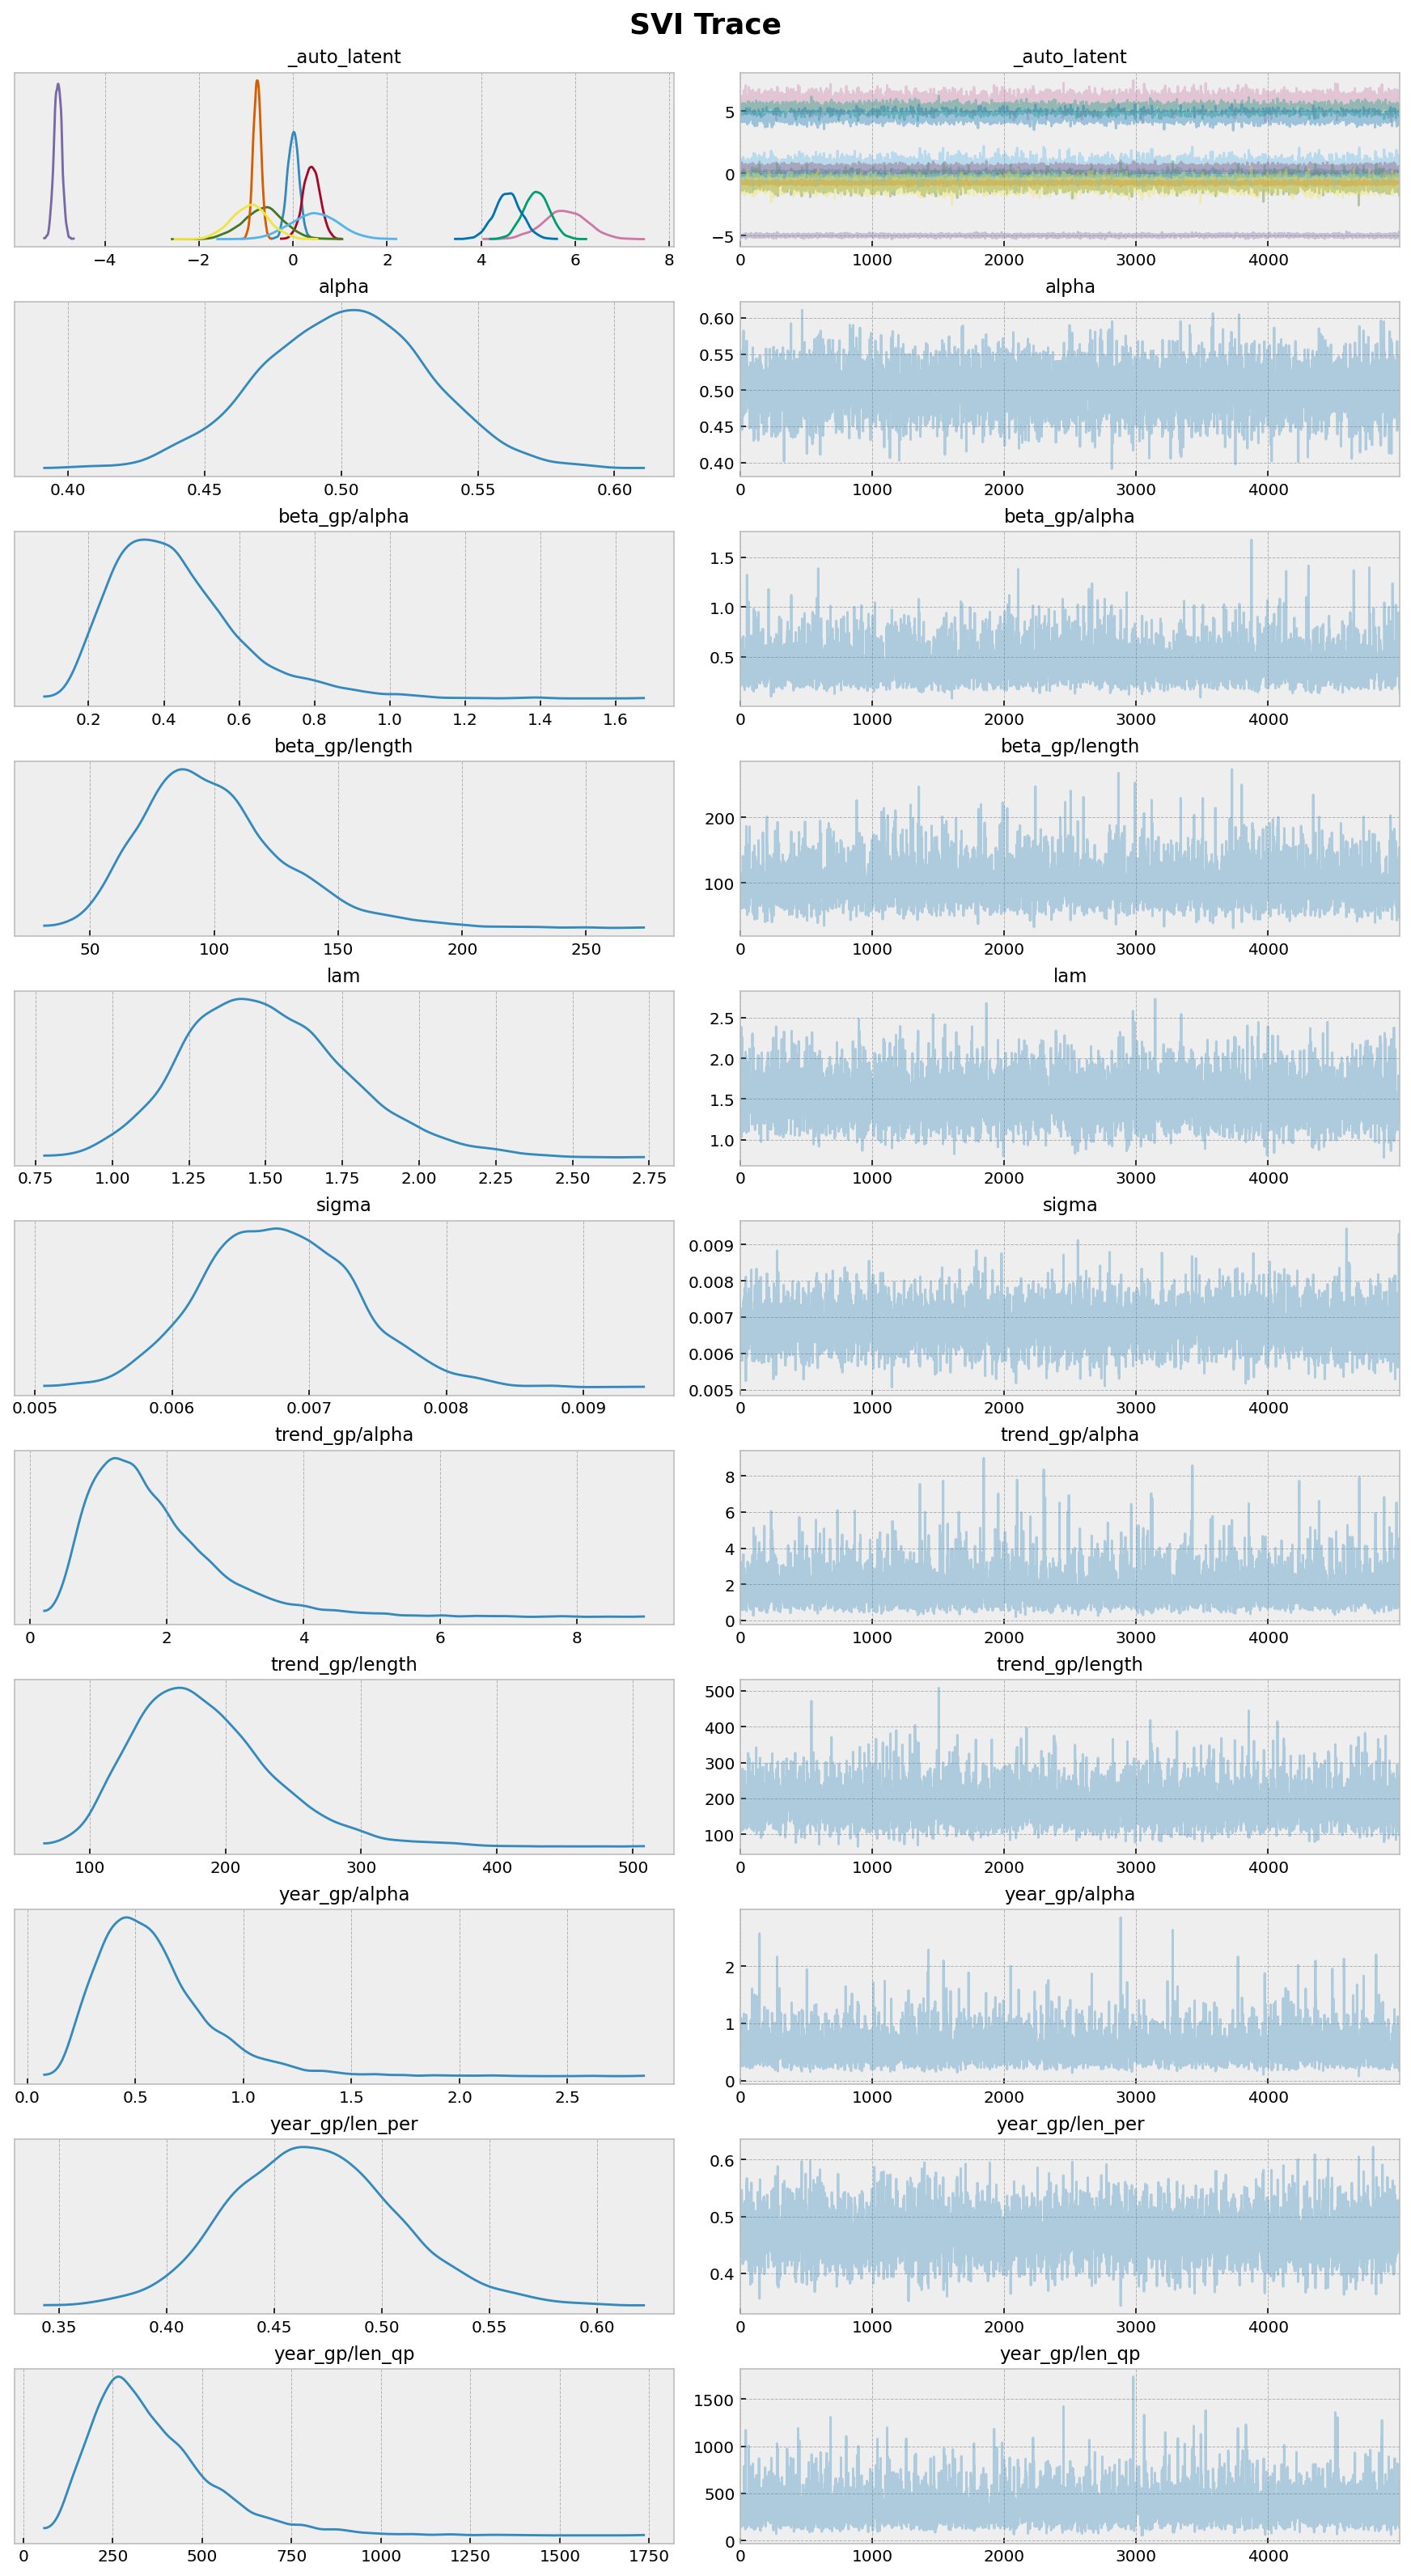

In [45]:
axes = az.plot_trace(
    data=idata_svi,
    compact=True,
   
    backend_kwargs={"layout": "constrained"},
)
plt.gcf().suptitle(t="SVI Trace", fontsize=18, fontweight="bold")

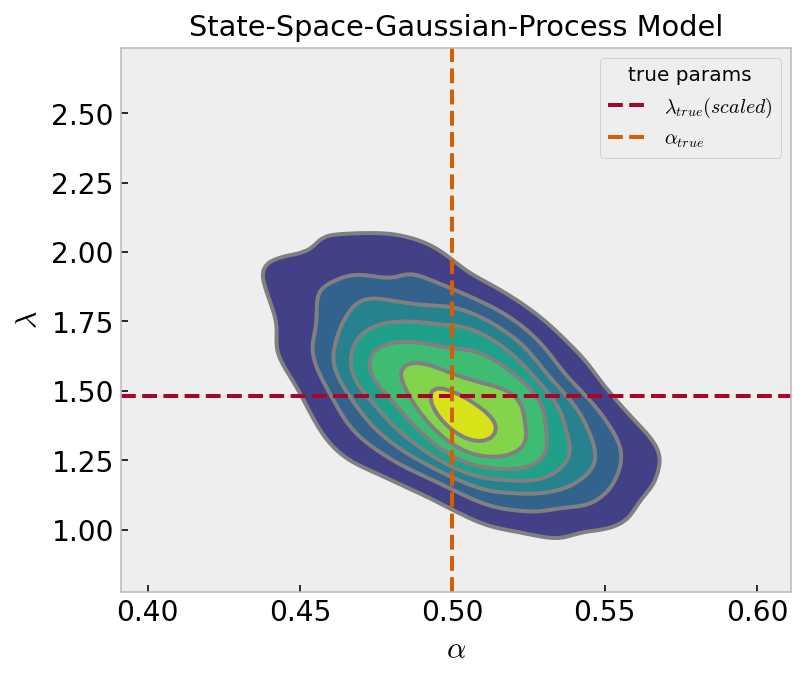

In [46]:
alpha_true = 0.5
lam_true = 0.15
lam_true_scaled = 0.15 * channel_scaler.scale_.item()

fig, ax = plt.subplots(figsize=(6, 5))
az.plot_pair(
    data=idata_svi,
    var_names=["alpha", "lam"],
    kind="kde",
    ax=ax
)
ax.axhline(lam_true_scaled, color="C1", linestyle="--", label="$\lambda_{true} (scaled)$")
ax.axvline(alpha_true, color="C4", linestyle="--", label="$\\alpha_{true}$")
ax.legend(title="true params", loc="upper right")
ax.set(
    title="State-Space-Gaussian-Process Model",
    xlabel="$\\alpha$",
    ylabel="$\lambda$"
);

In [47]:
alpha_posterior = az.extract(data=idata_svi, group="posterior", var_names="alpha")

alpha_posterior_samples = alpha_posterior.to_numpy()[:100]

# pass z through the adstock transformation
geometric_adstock_posterior_samples = np.array([
    geometric_adstock(x=z, alpha=x)
    for x in alpha_posterior_samples
])

### Posterior of $\alpha$
In the graph below the adstock variable conditional on the posterior distribution of the $\alpha$ parameter is compared with the adstock based on the tru value of $\alpha$

/tmp/ipykernel_779/3915406045.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  geometric_adstock_hdi = az.hdi(ary=geometric_adstock_posterior_samples)


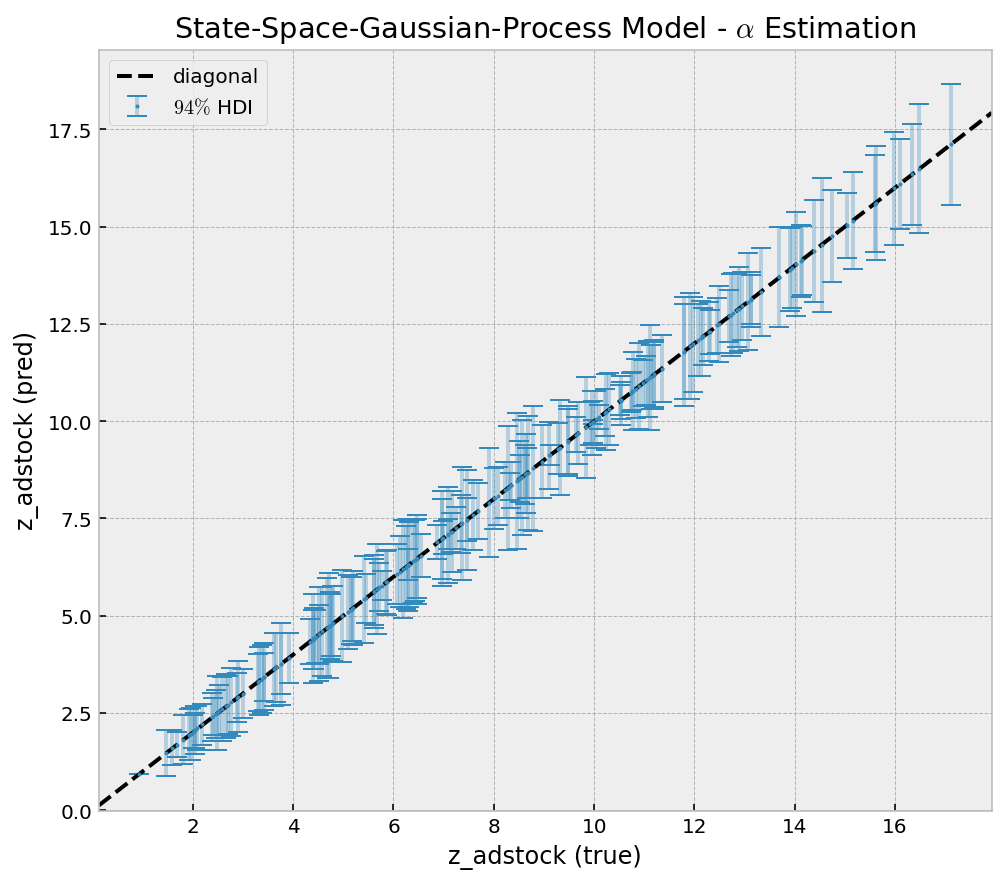

In [48]:
geometric_adstock_hdi = az.hdi(ary=geometric_adstock_posterior_samples)

yerr = geometric_adstock_hdi[:, 1] - geometric_adstock_hdi[:, 0]

fig, ax = plt.subplots(figsize=(8, 7))

markers, caps, bars = ax.errorbar(
    x=data_df["z_adstock"], 
    y=geometric_adstock_posterior_samples.mean(axis=0), 
    yerr=yerr/2,
    color="C0",
    fmt='o',
    ms=1,
    capsize=5,
    label="$94\%$ HDI",
)
[bar.set_alpha(0.3) for bar in bars]
ax.axline(
    xy1=(10, 10),
    slope=1.0,
    color="black",
    linestyle="--",
    label="diagonal"
)
ax.legend()
ax.set(
    title="State-Space-Gaussian-Process Model - $\\alpha$ Estimation",
    xlabel="z_adstock (true)",
    ylabel="z_adstock (pred)",
);

In [49]:
lam_posterior = (
    az.extract(data=idata_svi, group="posterior", var_names="lam")
    / channel_scaler.scale_.item()
)

lam_posterior_samples = lam_posterior.to_numpy()[:100]

logistic_saturation_posterior_samples = np.array(
    [
        logistic_saturation(x=x, lam=lam_posterior_samples)
        for x in data_df["z_adstock"].values
    ]
)

### Posterior of $\lambda$
The posterior of the $\lambda$ parameter controlling the adstock saturation captures the true transformation pretty accurately.

/tmp/ipykernel_779/431416226.py:1: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  logistic_saturation_hdi = az.hdi(ary=logistic_saturation_posterior_samples.T)


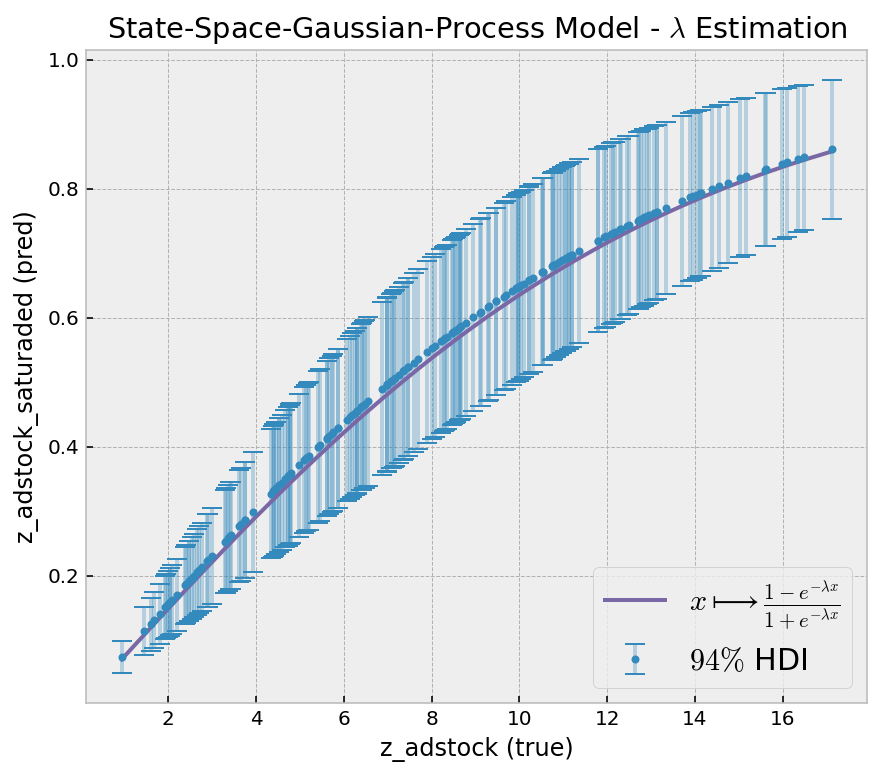

In [50]:
logistic_saturation_hdi = az.hdi(ary=logistic_saturation_posterior_samples.T)

yerr = logistic_saturation_hdi[:, 1] - logistic_saturation_hdi[:, 0]


fig, ax = plt.subplots(figsize=(7, 6))

latex_function = r"$x\longmapsto \frac{1 - e^{-\lambda x}}{1 + e^{-\lambda x}}$"

markers, caps, bars = ax.errorbar(
    x=data_df["z_adstock"], 
    y=logistic_saturation_posterior_samples.mean(axis=1), 
    yerr=yerr/2,
    color="C0",
    fmt='o',
    ms=3,
    capsize=5,
    label="$94\%$ HDI",
)
[bar.set_alpha(0.3) for bar in bars]
sns.lineplot(
    x="z_adstock",
    y="z_adstock_saturated",
    color="C2",
    label=latex_function,
    data=data_df,
    ax=ax
)
ax.legend(loc="lower right", prop={"size": 15})
ax.set(
    title="State-Space-Gaussian-Process Model - $\lambda$ Estimation",
    xlabel="z_adstock (true)",
    ylabel="z_adstock_saturaded (pred)",
);

### Z-effect posterior
We now move on to inspect the posterior distribution of the z-effect. The model returns the smoothed means and variances of the regression coefficient process $\beta(t)$ and the temporal Gaussian process. We multiply a sample from the regression coefficient process by the posterior of the saturated adstock variable. Note that since a sample from the posterior of $\beta(t)$ depends on $\alpha$ and $\lambda$, we need to make sure that the multiplied quantities are from the same MCMC iteration. 

In [51]:
beta_post_mean = samples['gp_posteriors'][0][:,:,0,0]
beta_post_var = samples['gp_posteriors'][1][:,:,0,0]
z_adstock_sat_post = samples['z_adstock_saturated']
z_effect_posterior = dist.Normal(beta_post_mean,beta_post_var).sample(rng_key)*z_adstock_sat_post


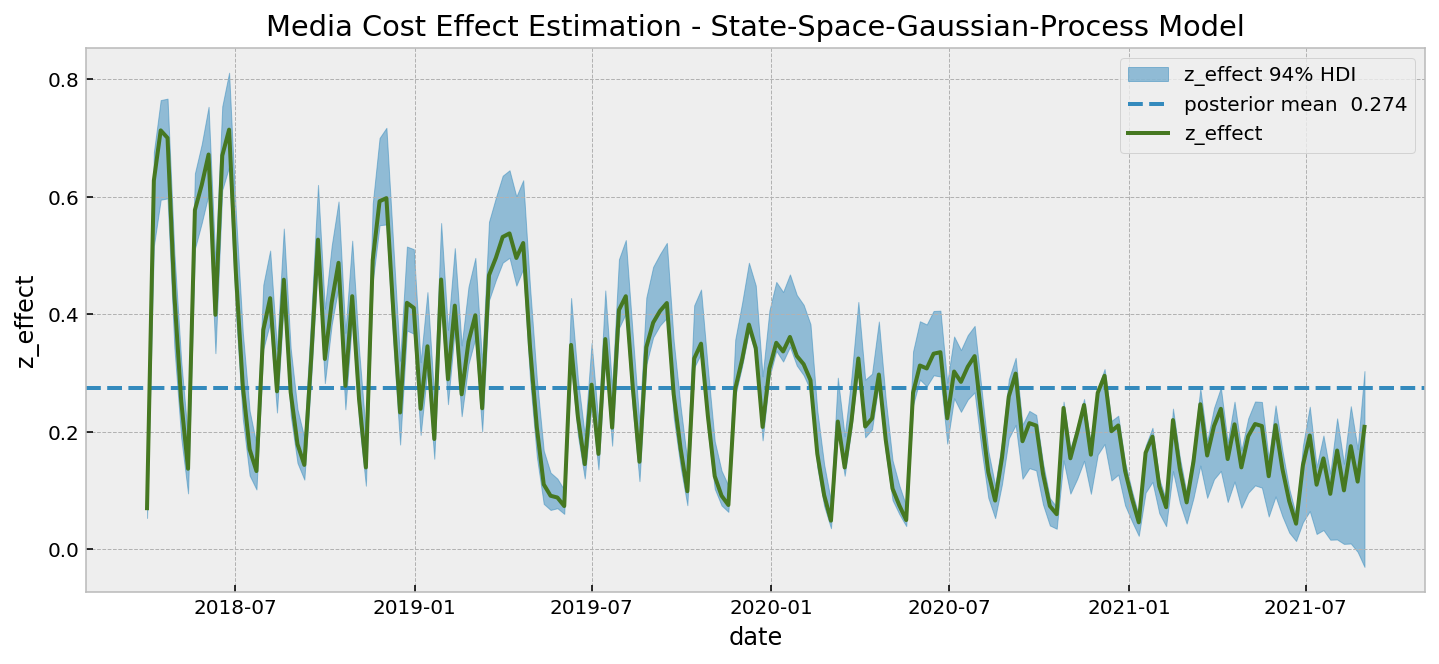

In [52]:
z_effect_posterior_samples = xr.apply_ufunc(
    lambda x: endog_scaler.inverse_transform(X=x.reshape(1, -1)),
    xr.DataArray(z_effect_posterior[None,:,:], dims=['chain','draw','date'], name='z_effect'),
    input_core_dims=[["date"]],
    output_core_dims=[["date"]],
    vectorize=True,
)

z_effect_hdi = az.hdi(ary=z_effect_posterior_samples)["z_effect"]

fig, ax = plt.subplots(figsize=(12,5))
ax.fill_between(
    x=date,
    y1=z_effect_hdi[:, 0],
    y2=z_effect_hdi[:, 1],
    color="C0",
    alpha=0.5,
    label="z_effect 94% HDI",
)
ax.axhline(
    y=z_effect_posterior_samples.mean(),
    color="C0",
    linestyle="--",
    label=f"posterior mean {z_effect_posterior_samples.mean().values: 0.3f}",
)
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, label="z_effect", ax=ax)
ax.legend(loc="upper right")
ax.set(
    title="Media Cost Effect Estimation - State-Space-Gaussian-Process Model"
);

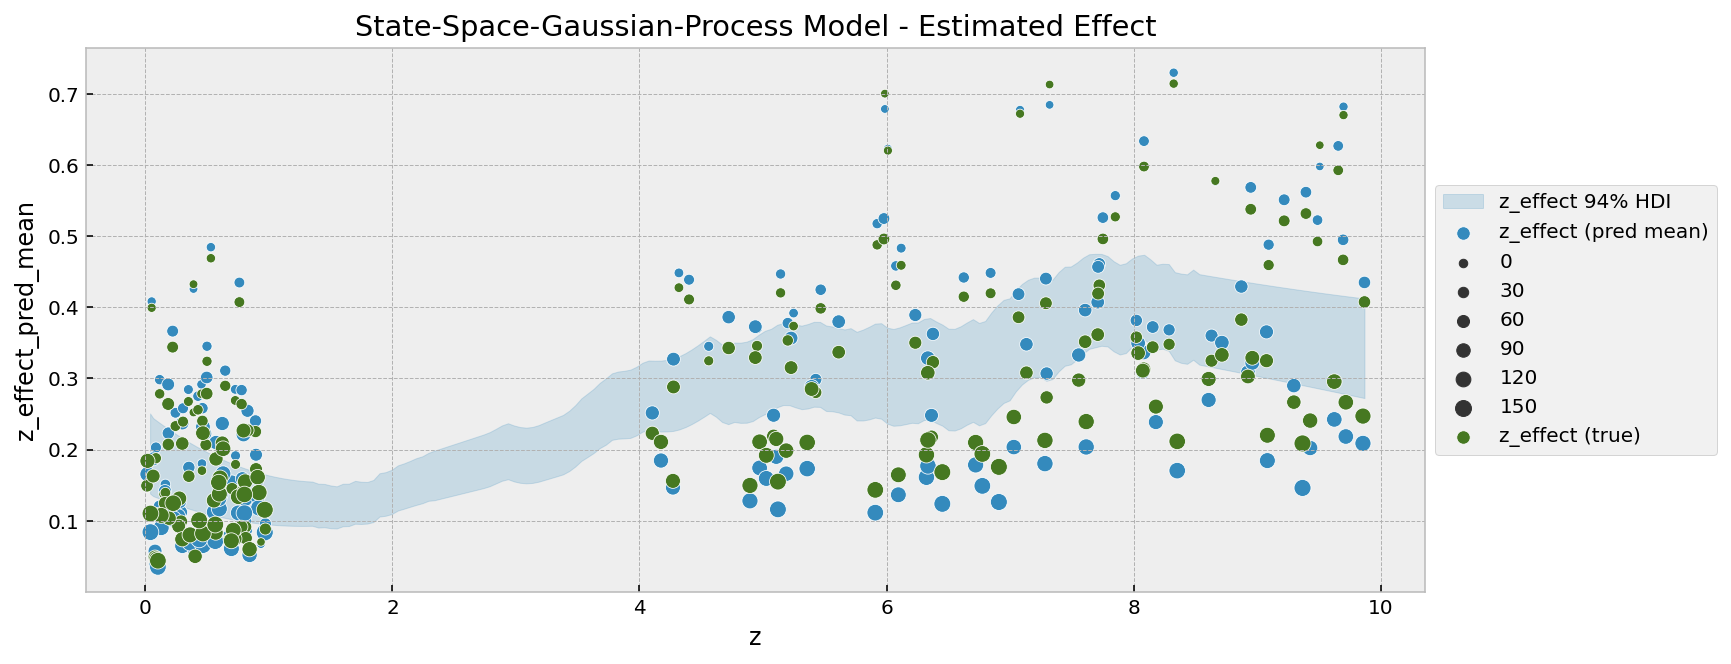

In [53]:
fig, ax = plt.subplots(figsize=(12,5))

az.plot_hdi(
    x=z,
    y=z_effect_posterior_samples,
    color="C0",
    fill_kwargs={"alpha": 0.2, "label": "z_effect 94% HDI"},
    ax=ax,
)
sns.scatterplot(
    x="z",
    y="z_effect_pred_mean",
    color="C0",
    size="index",
    label="z_effect (pred mean)",
    data=data_df.assign(
        z_effect_pred_mean=z_effect_posterior_samples.mean(dim=("chain", "draw"))
    ),
    ax=ax,
)
sns.scatterplot(
    x="z", y="z_effect", color="C3", size="index", label="z_effect (true)", data=data_df
)
h, l = ax.get_legend_handles_labels()
ax.legend(handles=h[:9], labels=l[:9], loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="State-Space-Gaussian-Process Model - Estimated Effect");

In [54]:
z_effect_hdi = az.hdi(ary=z_effect_posterior_samples)["z_effect"]

data_df = data_df.assign(
    z_effect_pred_mean=z_effect_posterior_samples.mean(dim=("chain", "draw")),
    z_effect_hdi_lower=z_effect_hdi[:, 0],
    z_effect_hdi_upper=z_effect_hdi[:, 1],
)

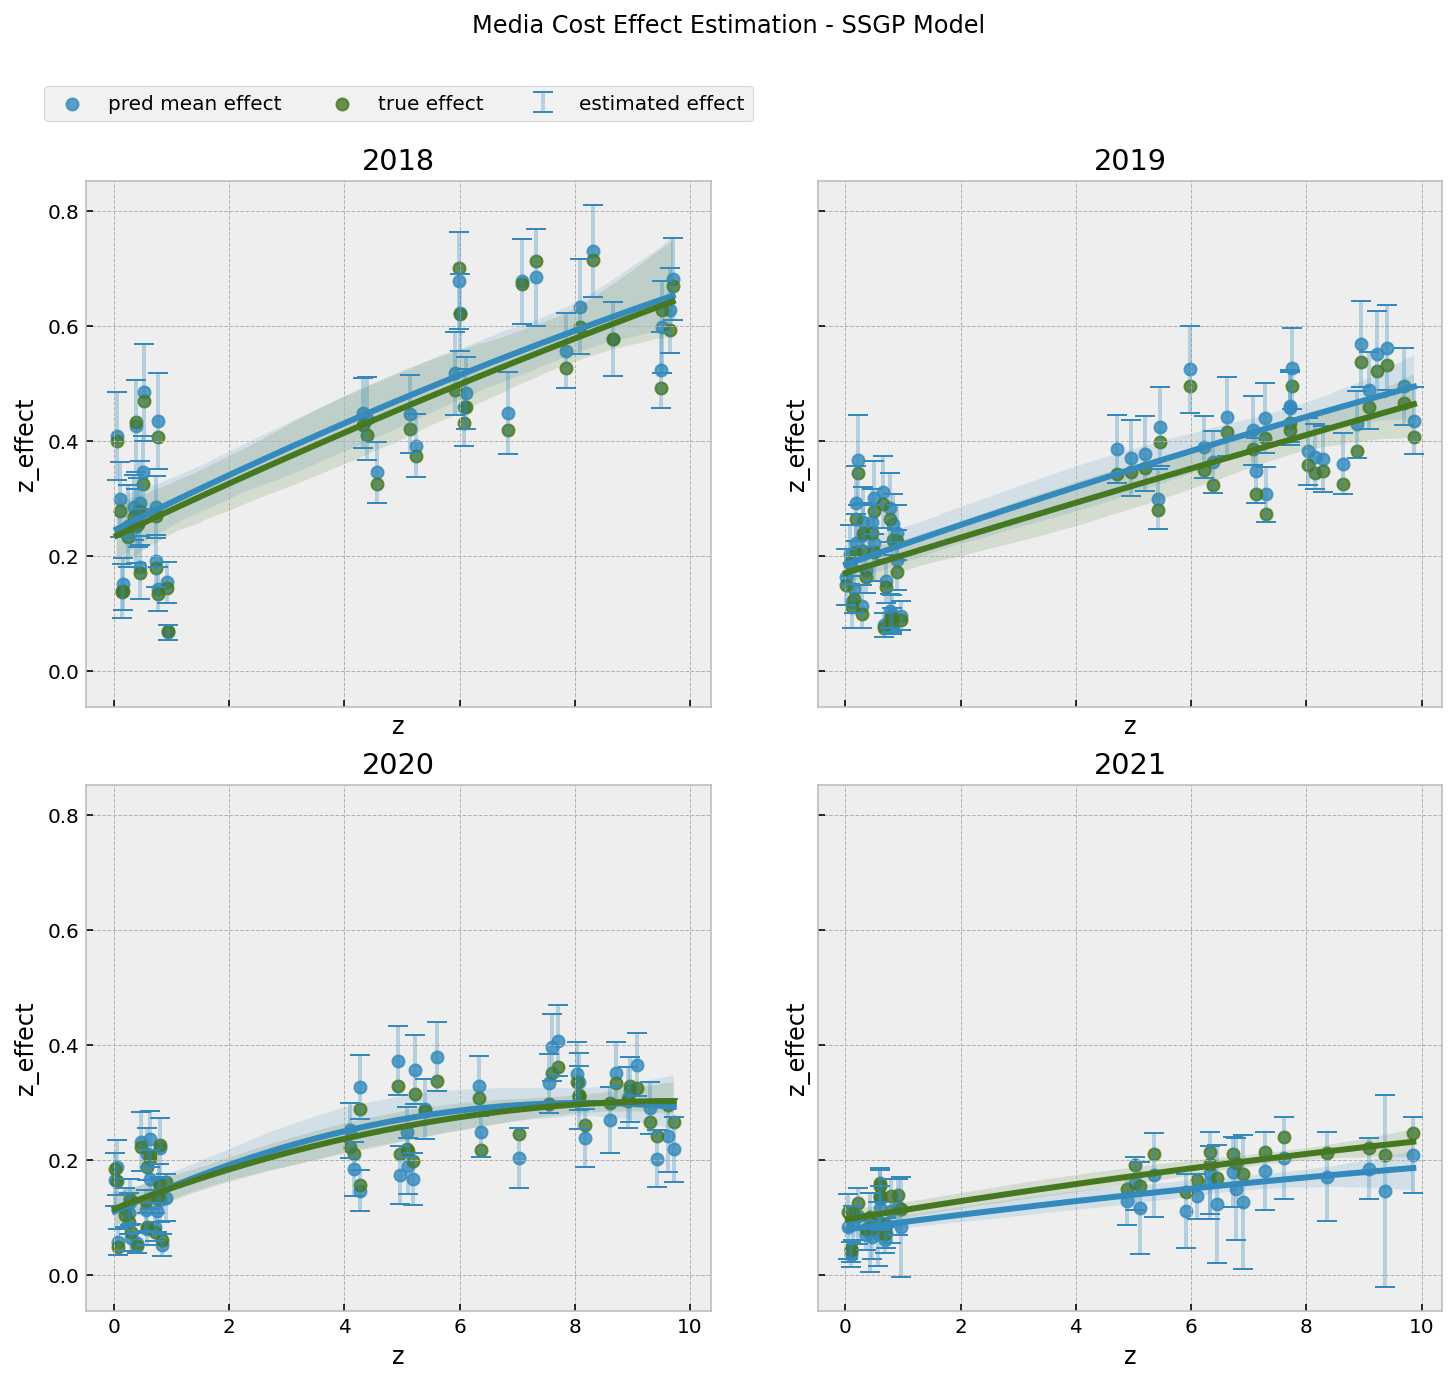

In [55]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(10, 9), sharex=True, sharey=True, layout="constrained"
)

axes = axes.flatten()

for i, year in enumerate(data_df["year"].sort_values().unique()):
    ax = axes[i]
    mask = f"year == {year}"

    yerr = (
        data_df.query(mask)["z_effect_hdi_upper"]
        - data_df.query(mask)["z_effect_hdi_lower"]
    )

    markers, caps, bars = ax.errorbar(
        x=data_df.query(mask)["z"],
        y=data_df.query(mask)["z_effect_pred_mean"],
        yerr=yerr / 2,
        color="C0",
        fmt="o",
        ms=0,
        capsize=5,
        label="estimated effect",
    )
    [bar.set_alpha(0.3) for bar in bars]
    sns.regplot(
        x="z",
        y="z_effect_pred_mean",
        order=2,
        color="C0",
        label="pred mean effect",
        data=data_df.query(mask),
        ax=ax,
    )
    sns.regplot(
        x="z",
        y="z_effect",
        order=2,
        color="C3",
        label="true effect",
        data=data_df.query(mask),
        ax=ax,
    )
    if i == 0:
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3)
    else:
        ax.legend().remove()
    ax.set(title=f"{year}")

fig.suptitle("Media Cost Effect Estimation - SSGP Model", y=1.05);

### ROAS estimates
One of the main quantities of interest in MM models is ROAS (Return On Ad Spend):
$$
ROAS = \frac{\sum^{n}_{t=0}\hat{f}(z_{t}, \xi_{t}) - \hat{f}(0, \xi_{t})}{\sum^{n}_{t=0} z_{t}}
$$
In the state space GP model the difference in the numerator equals the additive component $\hat{\beta}_t z(\hat{\alpha},\hat{\lambda})_t$ where $z(\hat{\alpha},\hat{\lambda})_t$ is the saturated adstock given the posteriors of $\alpha$ and $\lambda$. The $\hat{\beta}_t$ are sampled based on the smoothed mean and variance of the state vector.   

In [56]:
# true roas for z
roas_true = data_df["z_effect"].sum() / data_df["z"].sum()

roas_true

0.06620312360383751

In [57]:
ssgp_roas_numerator = endog_scaler.inverse_transform(
        X=z_effect_posterior.reshape((-1,len(z)))).sum(axis=-1)

roas_denominator = z.sum()

ssgp_roas = ssgp_roas_numerator / roas_denominator

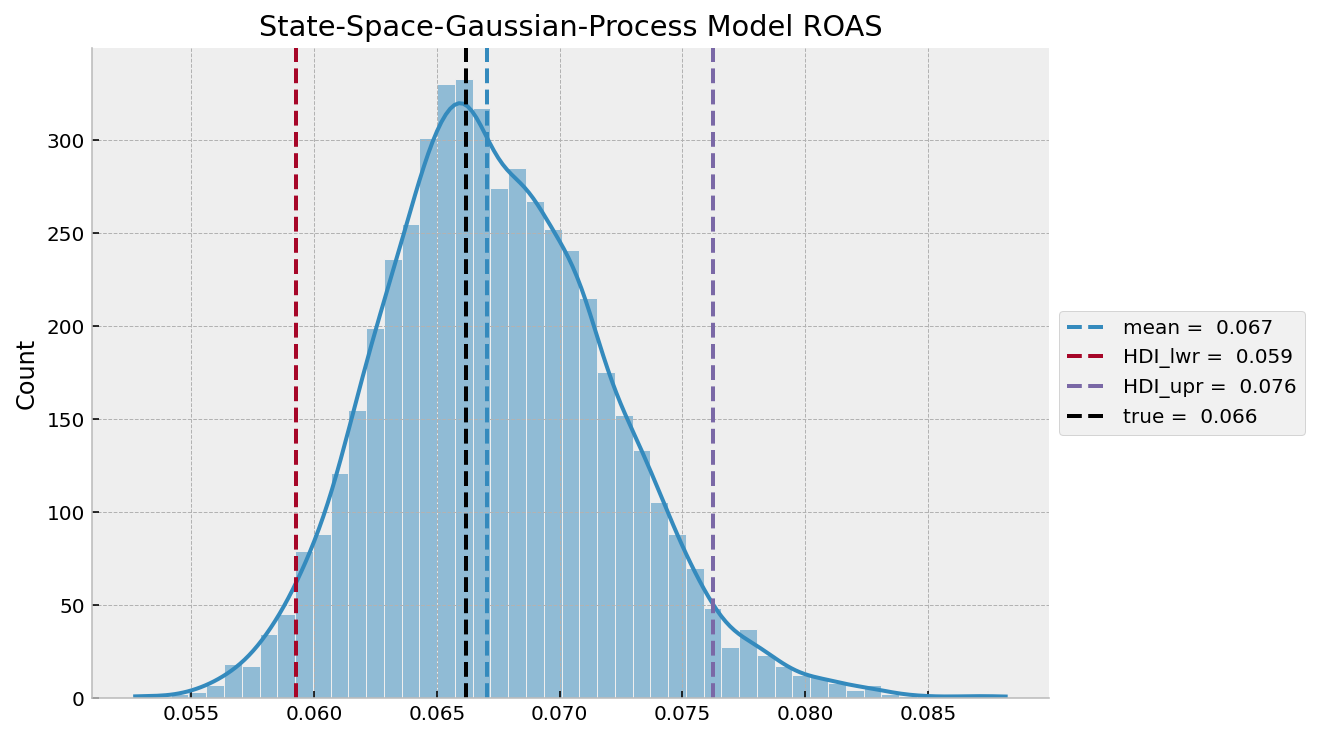

In [58]:
ssgp_roas_mean = np.median(ssgp_roas)
ssgp_roas_hdi = az.hdi(ary=ssgp_roas)

g = sns.displot(x=ssgp_roas, kde=True, height=5, aspect=1.5)
ax = g.axes.flatten()[0]
ax.axvline(
    x=ssgp_roas_mean, color="C0", linestyle="--", label=f"mean = {ssgp_roas_mean: 0.3f}"
)
ax.axvline(
    x=ssgp_roas_hdi[0],
    color="C1",
    linestyle="--",
    label=f"HDI_lwr = {ssgp_roas_hdi[0]: 0.3f}",
)
ax.axvline(
    x=ssgp_roas_hdi[1],
    color="C2",
    linestyle="--",
    label=f"HDI_upr = {ssgp_roas_hdi[1]: 0.3f}",
)
ax.axvline(x=roas_true, color="black", linestyle="--", label=f"true = {roas_true: 0.3f}")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="State-Space-Gaussian-Process Model ROAS");

The ROAS estimate is very close to the true value.

### mROAS estimation
The mROAS estimation here is based on applying the saturated adstock transformation on $\mathbf{z}_{\eta}=(1+\eta)\mathbf{z}$ with $\eta=0.10$, using the posterior sample of $\alpha$ and $\lambda$. These values are multiplied by a new sample from the posteriors of the regression coefficient process $\beta(t)$.

In [59]:
eta: float = 0.1
z_eta_adstock = geometric_adstock(x=(1+eta)*z_scaled, alpha=posterior_samples['alpha'], l_max=12)
z_eta_adstock_saturated = logistic_saturation(x=z_eta_adstock,lam=posterior_samples['lam'][:,None])

In [60]:
z_effect_eta_post = dist.Normal(beta_post_mean,beta_post_var).sample(random.PRNGKey(seed=3))*z_eta_adstock_saturated

In [61]:
ssgp_mroas_numerator = (
    endog_scaler.inverse_transform(
        X=z_effect_eta_post.reshape((-1,len(z)))

    )
    - endog_scaler.inverse_transform(
        X=z_effect_posterior.reshape((-1,len(z))),
        
    )
).sum(axis=-1)

mroas_denominator = eta * z.sum()

ssgp_mroas = ssgp_mroas_numerator / mroas_denominator

In [62]:
b_z_true = (np.arange(start=0.0, stop=1.0, step=1/n_obs) + 1) ** (-1.8)

z_effect_eta = b_z_true * logistic_saturation(
    x=geometric_adstock(x=(1 + eta) * z, alpha=0.5, l_max=12),
    lam=0.15
)

mroas_true = (z_effect_eta - data_df["z_effect"]).sum() / ( eta * z.sum())

mroas_true

0.04525924653065333

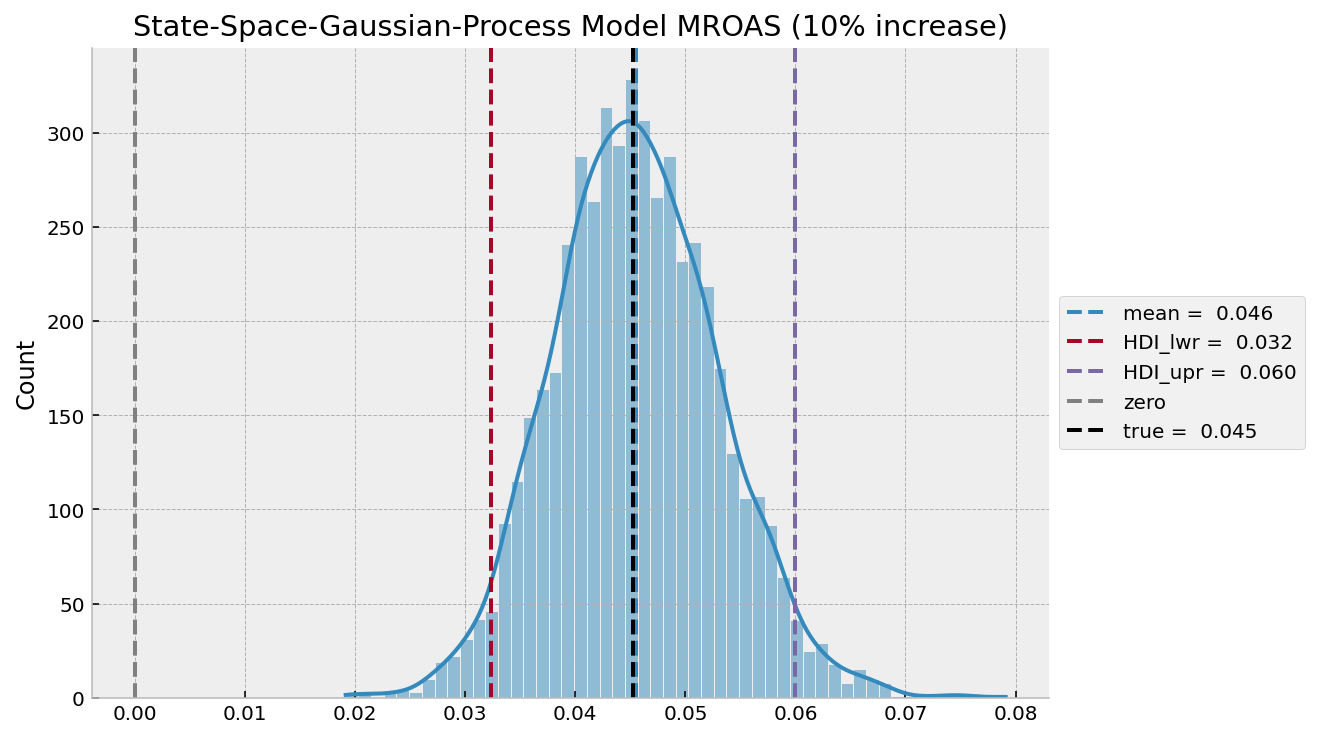

In [63]:
ssgp_mroas_mean = ssgp_mroas.mean()
ssgp_mroas_hdi = az.hdi(ary=ssgp_mroas)

g = sns.displot(x=ssgp_mroas, kde=True, height=5, aspect=1.5)
ax = g.axes.flatten()[0]
ax.axvline(
    x=ssgp_mroas_mean, color="C0", linestyle="--", label=f"mean = {ssgp_mroas_mean: 0.3f}"
)
ax.axvline(
    x=ssgp_mroas_hdi[0],
    color="C1",
    linestyle="--",
    label=f"HDI_lwr = {ssgp_mroas_hdi[0]: 0.3f}",
)
ax.axvline(
    x=ssgp_mroas_hdi[1],
    color="C2",
    linestyle="--",
    label=f"HDI_upr = {ssgp_mroas_hdi[1]: 0.3f}",
)
ax.axvline(x=0.0, color="gray", linestyle="--", label="zero")
ax.axvline(x=mroas_true, color="black", linestyle="--", label=f"true = {mroas_true: 0.3f}")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title=f"State-Space-Gaussian-Process Model MROAS ({eta:.0%} increase)");

The mROAS estimate is also very accurate.